In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDRegressor


# ========================
# 1️⃣ LOAD DATA
# ========================
df = pd.read_csv("insurance.csv")
df_original = df.copy()
print(f"Dataset loaded: {df.shape[0]} rows × {df.shape[1]} columns\n")


Dataset loaded: 1338 rows × 7 columns



In [11]:
# ========================
# 2️⃣ ADD MISSING VALUES (Demo)
# ========================
np.random.seed(42)
missing_percentage = 0.1
for col in ['age', 'bmi', 'children']:
    df.loc[np.random.choice(df.index, int(len(df)*missing_percentage), replace=False), col] = np.nan
for col in ['sex', 'smoker', 'region']:
    df.loc[np.random.choice(df.index, int(len(df)*missing_percentage), replace=False), col] = np.nan
df.loc[np.random.choice(df.index, int(len(df)*0.02), replace=False), 'charges'] = np.nan


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1205 non-null   float64
 1   sex       1205 non-null   object 
 2   bmi       1205 non-null   float64
 3   children  1205 non-null   float64
 4   smoker    1205 non-null   object 
 5   region    1205 non-null   object 
 6   charges   1312 non-null   float64
dtypes: float64(4), object(3)
memory usage: 73.3+ KB


In [13]:
# ========================
# 3️⃣ HANDLE MISSING VALUES
# ========================
num_cols = ['age', 'bmi', 'children']
cat_cols = ['sex', 'smoker', 'region']

# Encode categorical
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    mask = df[col].notna()
    df.loc[mask, col + '_encoded'] = le.fit_transform(df.loc[mask, col])
    df.loc[~mask, col + '_encoded'] = np.nan
    label_encoders[col] = le

# Iterative Imputer
impute_cols = num_cols + [c+'_encoded' for c in cat_cols] + ['charges']
df_impute = pd.DataFrame(
    IterativeImputer(max_iter=10, random_state=42, initial_strategy='mean').fit_transform(df[impute_cols]),
    columns=impute_cols
)

# Decode categorical
for col in cat_cols:
    df_impute[col+'_encoded'] = df_impute[col+'_encoded'].round().astype(int).clip(0, len(label_encoders[col].classes_)-1)
    df[col] = label_encoders[col].inverse_transform(df_impute[col+'_encoded'])
for col in num_cols + ['charges']:
    df[col] = df_impute[col]

# Drop temp encoded columns
df.drop(columns=[c+'_encoded' for c in cat_cols], inplace=True)


In [14]:

# ========================
# 4️⃣ SPLIT FEATURES & TARGET
# ========================
X = df.drop("charges", axis=1)
y = df["charges"]

# ========================
# 5️⃣ PREPROCESS PIPELINE
# ========================
preprocess = ColumnTransformer([
    ("onehot", OneHotEncoder(drop="first", sparse_output=False), cat_cols),
    ("scale", StandardScaler(), num_cols)
], remainder='passthrough')

model = Pipeline([
    ("preprocess", preprocess),
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("lasso", Lasso(alpha=0.01, max_iter=10000, random_state=42))
])

sgd_model = Pipeline([
    ("preprocess", preprocess),
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("sgd", SGDRegressor(
        loss='squared_error',
        penalty='l2',
        learning_rate='constant',
        eta0=0.001,
        max_iter=1,
        warm_start=True,
        random_state=42
    ))
])


# ========================
# 6️⃣ TRAIN/TEST SPLIT & TRAIN
# ========================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.148e+08, tolerance: 1.535e+07
  model = cd_fast.enet_coordinate_descent(


Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['sex', 'smoker', 'region']),
                                                 ('scale', StandardScaler(),
                                                  ['age', 'bmi',
                                                   'children'])])),
                ('poly', PolynomialFeatures(include_bias=False)),
                ('lasso', Lasso(alpha=0.01, max_iter=10000, random_state=42))])

In [15]:
# ========================
# 7️⃣ EVALUATION
# ========================
def evaluate(y_true, y_pred, name=""):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{name} MAE: ${mae:,.2f}, RMSE: ${rmse:,.2f}, R²: {r2:.4f}")
    return mae, rmse, r2

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
train_mae, train_rmse, train_r2 = evaluate(y_train, y_train_pred, "Train")
test_mae, test_rmse, test_r2 = evaluate(y_test, y_test_pred, "Test")


Train MAE: $3,001.96, RMSE: $4,850.88, R²: 0.8359
Test MAE: $3,125.69, RMSE: $4,719.92, R²: 0.8541


In [17]:
epochs = 100
train_losses = []
test_losses = []

for epoch in range(epochs):
    sgd_model.fit(X_train, y_train)

    y_train_pred = sgd_model.predict(X_train)
    y_test_pred = sgd_model.predict(X_test)

    train_loss = mean_squared_error(y_train, y_train_pred)
    test_loss = mean_squared_error(y_test, y_test_pred)

    train_losses.append(train_loss)
    test_losses.append(test_loss)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1608: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1608: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1608: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1608: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stocha

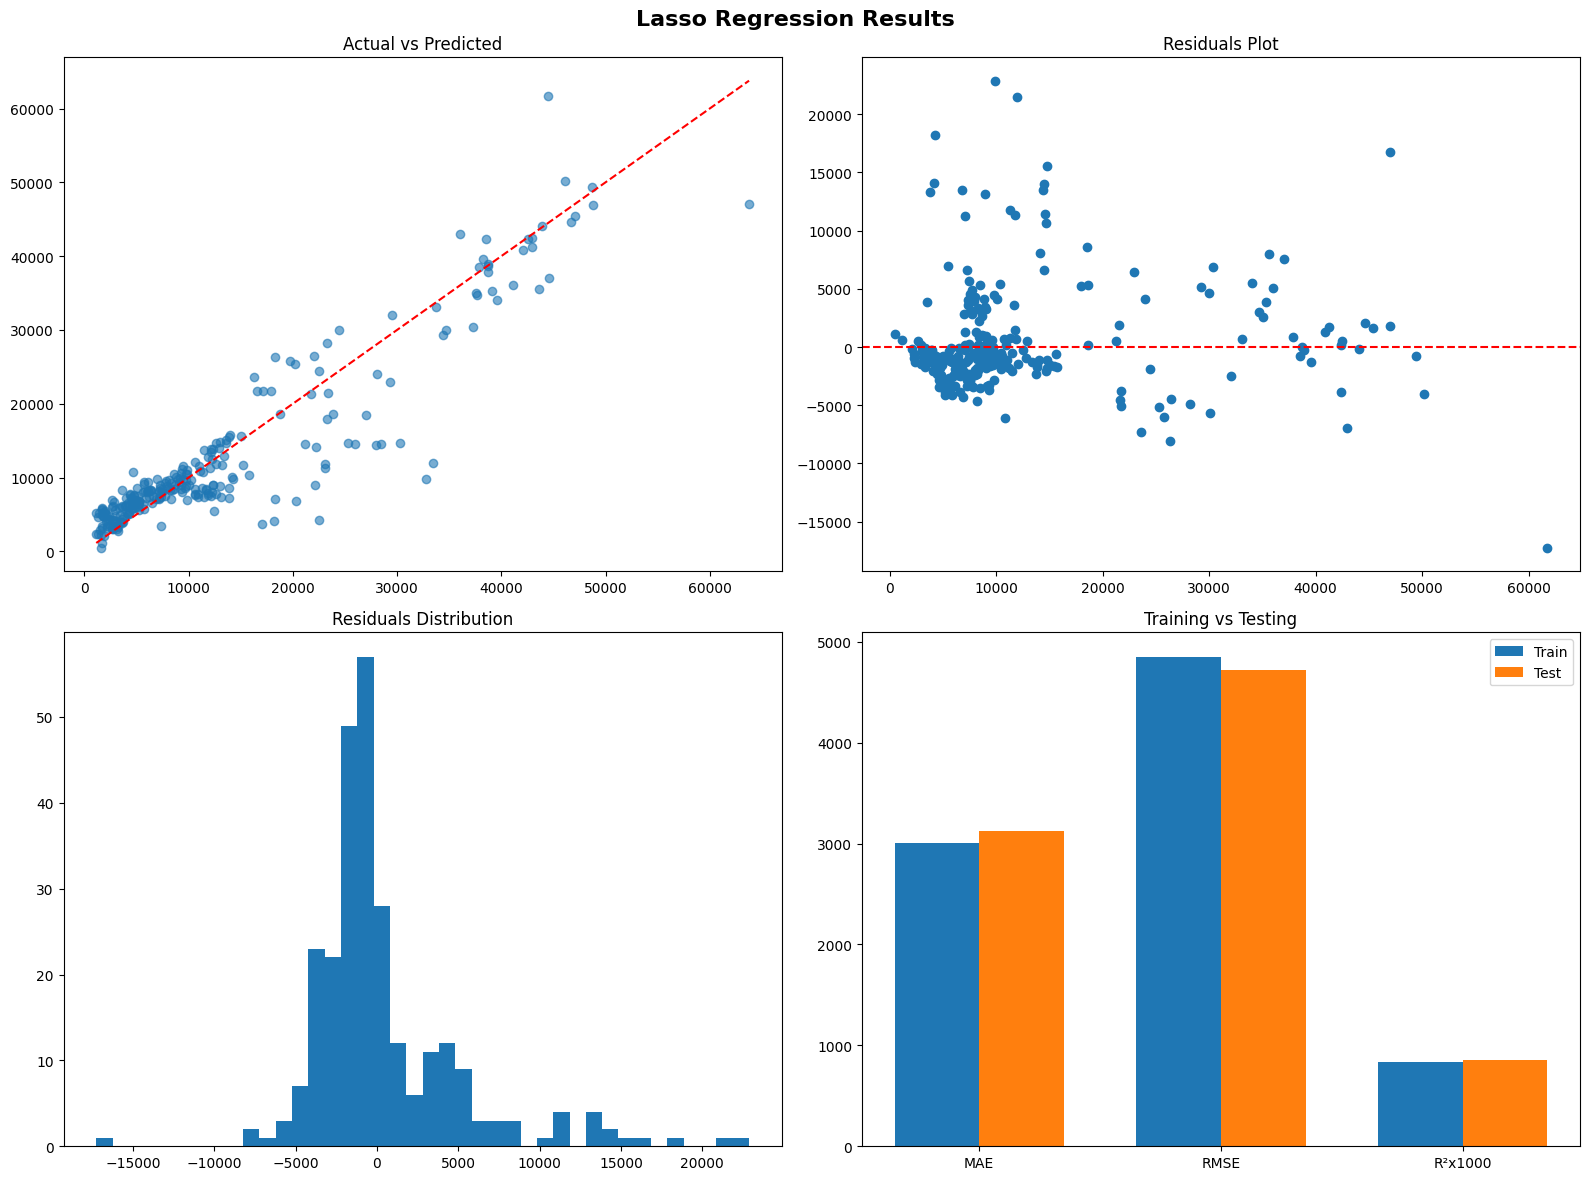

In [18]:

# ========================
# 8️⃣ VISUALIZATION
# ========================
fig, axes = plt.subplots(2, 2, figsize=(16,12))
fig.suptitle('Lasso Regression Results', fontsize=16, fontweight='bold')

# Actual vs Predicted
axes[0,0].scatter(y_test, y_test_pred, alpha=0.6)
axes[0,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[0,0].set_title('Actual vs Predicted')

# Residuals plot
residuals = y_test - y_test_pred
axes[0,1].scatter(y_test_pred, residuals)
axes[0,1].axhline(0, color='red', linestyle='--')
axes[0,1].set_title('Residuals Plot')

# Residuals distribution
axes[1,0].hist(residuals, bins=40)
axes[1,0].set_title('Residuals Distribution')

# Metrics comparison
metrics = ['MAE','RMSE','R²x1000']
train_vals = [train_mae, train_rmse, train_r2*1000]
test_vals = [test_mae, test_rmse, test_r2*1000]
x = np.arange(len(metrics))
width = 0.35
axes[1,1].bar(x-width/2, train_vals, width, label='Train')
axes[1,1].bar(x+width/2, test_vals, width, label='Test')
axes[1,1].set_xticks(x)
axes[1,1].set_xticklabels(metrics)
axes[1,1].set_title('Training vs Testing')
axes[1,1].legend()

plt.tight_layout()
plt.show()



In [19]:

# ========================
# 9️⃣ PREDICTION EXAMPLES
# ========================
def predict_example(example_df):
    pred = model.predict(example_df)[0]
    return f"Predicted Cost: ${pred:,.2f}"

example1 = pd.DataFrame({'age':[30],'sex':['male'],'bmi':[25],'children':[1],'smoker':['no'],'region':['southwest']})
example2 = pd.DataFrame({'age':[30],'sex':['male'],'bmi':[25],'children':[1],'smoker':['yes'],'region':['southwest']})
print("Non-smoker:", predict_example(example1))
print("Smoker:    ", predict_example(example2))


Non-smoker: Predicted Cost: $4,477.68
Smoker:     Predicted Cost: $22,039.58


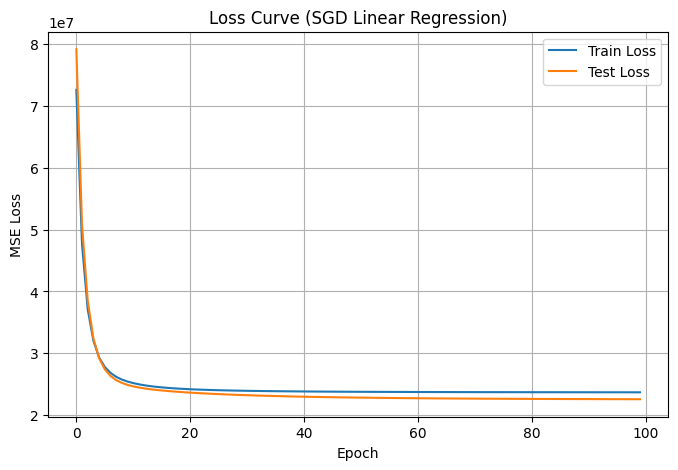

In [20]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Loss Curve (SGD Linear Regression)")
plt.legend()
plt.grid(True)
plt.show()


# knn

In [21]:
from sklearn.neighbors import KNeighborsRegressor
knn_model = Pipeline([
    ("preprocess", preprocess),
    ("knn", KNeighborsRegressor(n_neighbors=5))
])
knn_model.fit(X_train, y_train)
y_train_pred_knn = knn_model.predict(X_train)
y_test_pred_knn = knn_model.predict(X_test)

train_mae_knn, train_rmse_knn, train_r2_knn = evaluate(y_train, y_train_pred_knn, "Train KNN")
test_mae_knn, test_rmse_knn, test_r2_knn = evaluate(y_test, y_test_pred_knn, "Test KNN")


Train KNN MAE: $3,252.09, RMSE: $5,420.31, R²: 0.7952
Test KNN MAE: $4,163.72, RMSE: $6,524.16, R²: 0.7213


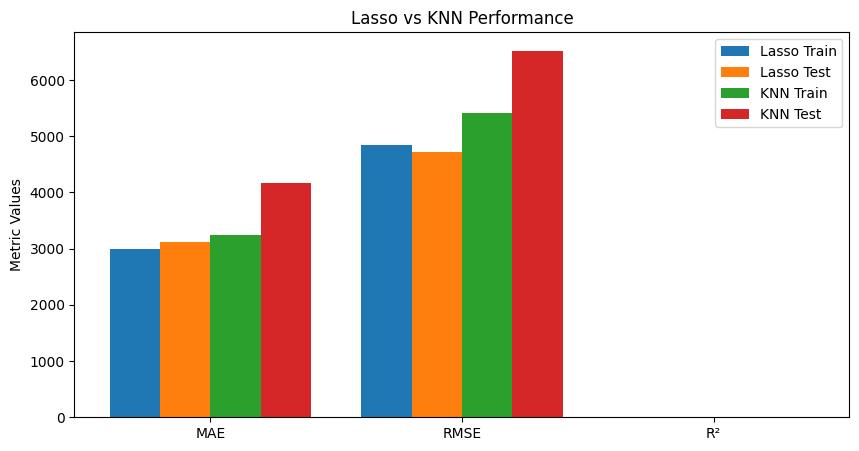

In [22]:
import matplotlib.pyplot as plt

metrics = ['MAE','RMSE','R²']
lasso_train = [train_mae, train_rmse, train_r2]
lasso_test  = [test_mae, test_rmse, test_r2]
knn_train   = [train_mae_knn, train_rmse_knn, train_r2_knn]
knn_test    = [test_mae_knn, test_rmse_knn, test_r2_knn]

x = np.arange(len(metrics))
width = 0.2

plt.figure(figsize=(10,5))
plt.bar(x-0.3, lasso_train, width, label='Lasso Train')
plt.bar(x-0.1, lasso_test, width, label='Lasso Test')
plt.bar(x+0.1, knn_train, width, label='KNN Train')
plt.bar(x+0.3, knn_test, width, label='KNN Test')
plt.xticks(x, metrics)
plt.ylabel("Metric Values")
plt.title("Lasso vs KNN Performance")
plt.legend()
plt.show()


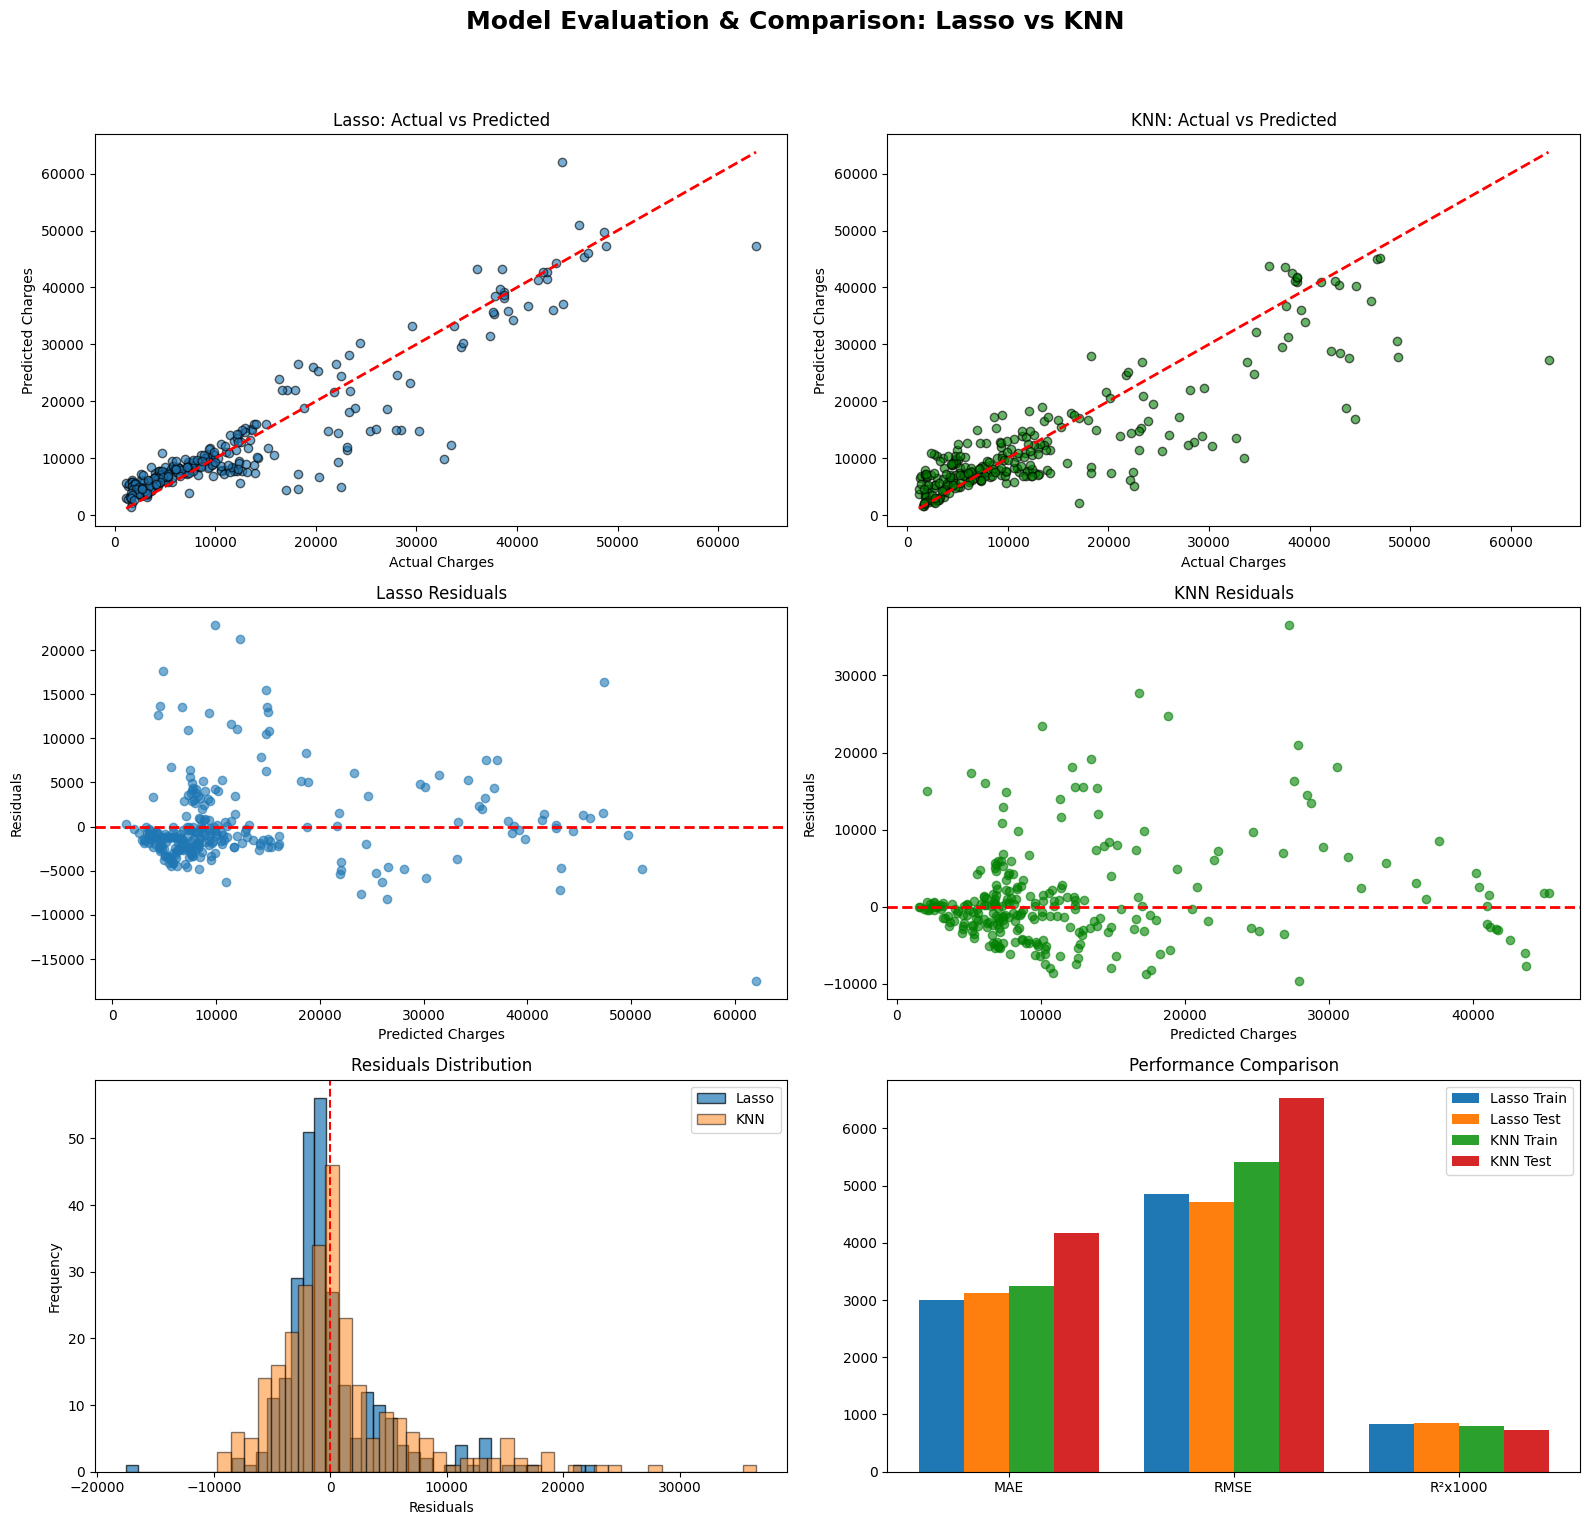

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# ======= Predictions =======
y_test_pred_lasso = model.predict(X_test)
y_test_pred_knn   = knn_model.predict(X_test)

residuals_lasso = y_test - y_test_pred_lasso
residuals_knn   = y_test - y_test_pred_knn

# ======= Create Subplots =======
fig, axes = plt.subplots(3, 2, figsize=(16,16))
fig.suptitle('Model Evaluation & Comparison: Lasso vs KNN', fontsize=18, fontweight='bold')

# 1. Actual vs Predicted - Lasso
axes[0,0].scatter(y_test, y_test_pred_lasso, alpha=0.6, edgecolors='black')
axes[0,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0,0].set_title('Lasso: Actual vs Predicted')
axes[0,0].set_xlabel('Actual Charges')
axes[0,0].set_ylabel('Predicted Charges')

# 2. Actual vs Predicted - KNN
axes[0,1].scatter(y_test, y_test_pred_knn, alpha=0.6, edgecolors='black', color='green')
axes[0,1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0,1].set_title('KNN: Actual vs Predicted')
axes[0,1].set_xlabel('Actual Charges')
axes[0,1].set_ylabel('Predicted Charges')

# 3. Residuals Plot - Lasso
axes[1,0].scatter(y_test_pred_lasso, residuals_lasso, alpha=0.6)
axes[1,0].axhline(0, color='red', linestyle='--', lw=2)
axes[1,0].set_title('Lasso Residuals')
axes[1,0].set_xlabel('Predicted Charges')
axes[1,0].set_ylabel('Residuals')

# 4. Residuals Plot - KNN
axes[1,1].scatter(y_test_pred_knn, residuals_knn, alpha=0.6, color='green')
axes[1,1].axhline(0, color='red', linestyle='--', lw=2)
axes[1,1].set_title('KNN Residuals')
axes[1,1].set_xlabel('Predicted Charges')
axes[1,1].set_ylabel('Residuals')

# 5. Residuals Distribution
axes[2,0].hist(residuals_lasso, bins=40, alpha=0.7, label='Lasso', edgecolor='black')
axes[2,0].hist(residuals_knn, bins=40, alpha=0.5, label='KNN', edgecolor='black')
axes[2,0].axvline(0, color='red', linestyle='--')
axes[2,0].set_title('Residuals Distribution')
axes[2,0].set_xlabel('Residuals')
axes[2,0].set_ylabel('Frequency')
axes[2,0].legend()

# 6. Metrics Comparison
metrics = ['MAE','RMSE','R²x1000']
lasso_train_vals = [train_mae, train_rmse, train_r2*1000]
lasso_test_vals  = [test_mae, test_rmse, test_r2*1000]
knn_train_vals   = [train_mae_knn, train_rmse_knn, train_r2_knn*1000]
knn_test_vals    = [test_mae_knn, test_rmse_knn, test_r2_knn*1000]

x = np.arange(len(metrics))
width = 0.2

axes[2,1].bar(x-0.3, lasso_train_vals, width, label='Lasso Train')
axes[2,1].bar(x-0.1, lasso_test_vals, width, label='Lasso Test')
axes[2,1].bar(x+0.1, knn_train_vals, width, label='KNN Train')
axes[2,1].bar(x+0.3, knn_test_vals, width, label='KNN Test')
axes[2,1].set_xticks(x)
axes[2,1].set_xticklabels(metrics)
axes[2,1].set_title('Performance Comparison')
axes[2,1].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
